In [1]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5099371268234668984
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3076812800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15005895206477730617
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [4]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Food 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,2777,"To be completely fair, the only redeeming fact...",food,1
1,1634,"The food is uniformly exceptional, with a very...",food,1
2,2846,"Not only was the food outstanding, but the lit...",food,1
3,1571,It is very overpriced and not very tasty.,food,0
4,1458,Our agreed favorite is the orrechiete with sau...,food,1


In [5]:
df.dtypes

id          object
text        object
category    object
polarity     int64
dtype: object

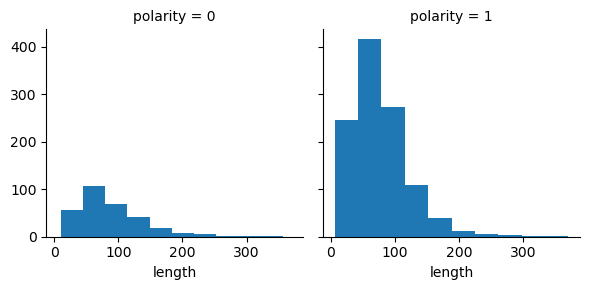

In [6]:
# review data의 길이 분포 및 통계
df_new=df
df_new['length'] = df['text'].apply(len)

# Create a FacetGrid object with 'Liked' as the column to be used for separating the data
# FacetGrid is a grid of subplots that displays the same relationship between different subsets of your data.
g = sns.FacetGrid(df, col='polarity')

# Use the FacetGrid object to plot a histogram of the 'Length' column for each value of 'Liked'
g.map(plt.hist, 'length');

In [7]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 1107, negative: 308


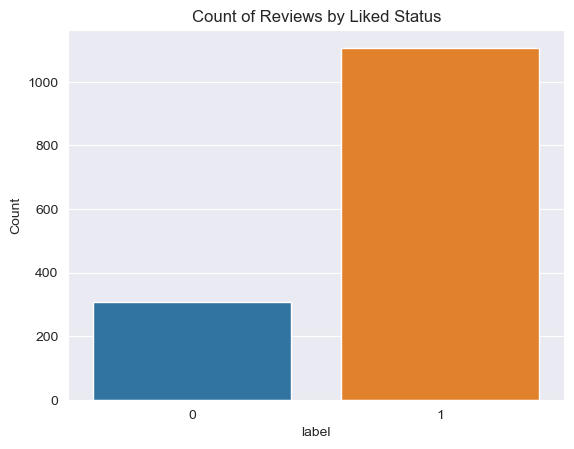

In [8]:
# review data의 label 분포
sns.set_style('darkgrid')

# Create a count plot of the "Liked" column
sns.countplot(x='polarity', data=df)

# Set the title of the plot
plt.title('Count of Reviews by Liked Status')

# Set the label for the x-axis
plt.xlabel('label')

# Set the label for the y-axis
plt.ylabel('Count')

# Show the plot
plt.show()

In [9]:
df_new.length.describe()

count    1415.000000
mean       79.168198
std        46.640079
min         6.000000
25%        47.500000
50%        70.000000
75%       102.000000
max       370.000000
Name: length, dtype: float64

In [10]:
text = df.text.values
labels = df.polarity.values

In [11]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [12]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [13]:
VAL_RATIO= 0.2
batch_size = 8 # 16 or 32 추천이라고 한다

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 1132
validation: 283


In [14]:

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [15]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))
    #print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    #print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    #print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:   7%|█████                                                                       | 1/15 [00:12<02:55, 12.55s/it]


	 - Train loss: 0.3524
	 - Validation Accuracy: 0.9132


Epoch:  13%|██████████▏                                                                 | 2/15 [00:23<02:28, 11.44s/it]


	 - Train loss: 0.1820
	 - Validation Accuracy: 0.9062


Epoch:  20%|███████████████▏                                                            | 3/15 [00:33<02:12, 11.06s/it]


	 - Train loss: 0.1157
	 - Validation Accuracy: 0.8993


Epoch:  27%|████████████████████▎                                                       | 4/15 [00:44<01:59, 10.84s/it]


	 - Train loss: 0.0817
	 - Validation Accuracy: 0.8819


Epoch:  33%|█████████████████████████▎                                                  | 5/15 [00:54<01:47, 10.72s/it]


	 - Train loss: 0.0410
	 - Validation Accuracy: 0.9132


Epoch:  40%|██████████████████████████████▍                                             | 6/15 [01:05<01:35, 10.66s/it]


	 - Train loss: 0.0140
	 - Validation Accuracy: 0.9062


Epoch:  47%|███████████████████████████████████▍                                        | 7/15 [01:15<01:24, 10.61s/it]


	 - Train loss: 0.0205
	 - Validation Accuracy: 0.9132


Epoch:  53%|████████████████████████████████████████▌                                   | 8/15 [01:26<01:14, 10.58s/it]


	 - Train loss: 0.0174
	 - Validation Accuracy: 0.9028


Epoch:  60%|█████████████████████████████████████████████▌                              | 9/15 [01:36<01:03, 10.57s/it]


	 - Train loss: 0.0807
	 - Validation Accuracy: 0.8924


Epoch:  67%|██████████████████████████████████████████████████                         | 10/15 [01:47<00:52, 10.56s/it]


	 - Train loss: 0.0390
	 - Validation Accuracy: 0.9028


Epoch:  73%|██████████████████████████████████████████████████████▉                    | 11/15 [01:58<00:42, 10.55s/it]


	 - Train loss: 0.0067
	 - Validation Accuracy: 0.8993


Epoch:  80%|████████████████████████████████████████████████████████████               | 12/15 [02:08<00:31, 10.55s/it]


	 - Train loss: 0.0378
	 - Validation Accuracy: 0.8924


Epoch:  87%|█████████████████████████████████████████████████████████████████          | 13/15 [02:19<00:21, 10.55s/it]


	 - Train loss: 0.0195
	 - Validation Accuracy: 0.9132


Epoch:  93%|██████████████████████████████████████████████████████████████████████     | 14/15 [02:29<00:10, 10.55s/it]


	 - Train loss: 0.0058
	 - Validation Accuracy: 0.9097


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 15/15 [02:40<00:00, 10.68s/it]


	 - Train loss: 0.0387
	 - Validation Accuracy: 0.9062


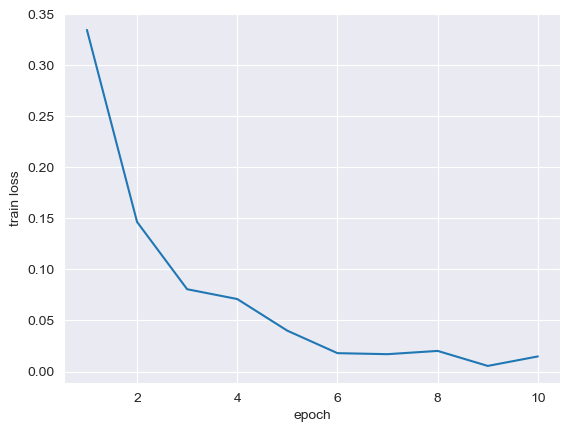

In [16]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

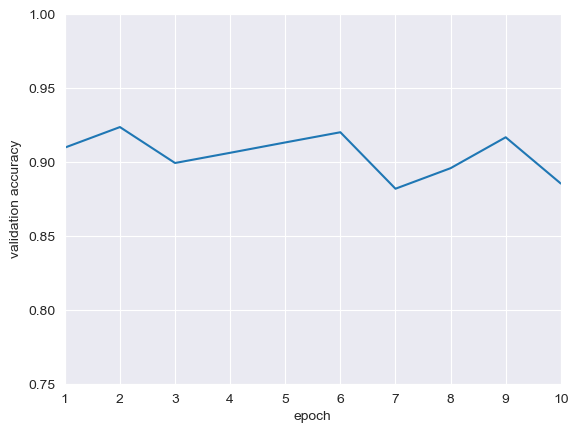

In [17]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [17]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [18]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_test.csv'
df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,3440,"Even though its good seafood, the prices are t...",aa,1
1,en_CatalRestaurant__UvaBar_477861889:4,My g/f and I both agreed the food was very med...,food,0
2,1242,But the coconut rice was good.,food,1
3,en_BlueRibbonSushi_478218345:2,It has great sushi and even better service.,food,1
4,882,"While the ambiance and atmosphere were great, ...",food,0


In [19]:
count_neg = len(df[df['polarity'] == 0])
count_pos=len(df[df['polarity'] == 1])
print("positive: {}, negative: {}".format(count_pos,count_neg))

positive: 46, negative: 34


In [20]:
count=0

test_text = df.text.values
test_labels = df.polarity.values

wrongResult=[]
rightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        rightResult.append(t)
    else:
        wrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
    

=============================== Input 1 ===============================
Even though its good seafood, the prices are too high.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
My g/f and I both agreed the food was very mediocre especially considering the price.
model result: Positive 
answer: 0 

=============================== Input 3 ===============================
But the coconut rice was good.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It has great sushi and even better service.
model result: Positive 
answer: 1 

=============================== Input 5 ===============================
While the ambiance and atmosphere were great, the food and service could have been a lot better.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The food was lousy -too sweet or too salty and the portions tiny.
model res

=============================== Input 74 ===============================
The food was great.
model result: Positive 
answer: 1 

=============================== Input 75 ===============================
I swore never to return for a warm beer and mediocre meal.
model result: Negative 
answer: 0 

=============================== Input 76 ===============================
Don't leave the restaurant without it.
model result: Negative 
answer: 1 

=============================== Input 77 ===============================
The onion rings are great!
model result: Positive 
answer: 1 

=============================== Input 78 ===============================
Good food!
model result: Positive 
answer: 1 

=============================== Input 79 ===============================
With the theater 2 blocks away we had a delicious meal in a beautiful room.
model result: Positive 
answer: 1 

=============================== Input 80 ===============================
very good breads as well.
model result: P

In [21]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [22]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [23]:
# 개별 문장의 attention 추출
from bertviz import head_view

sent="Terrible service, but food was delicious, and cost-effective."

# 전처리
encoding = preprocessing(sent, tokenizer,20)


retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

print('입력 문장:', sent)
print('분류:', prediction)
print()

#head_view(retAtt,retTok)


입력 문장: Terrible service, but food was delicious, and cost-effective.
분류: Positive



In [24]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [25]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [26]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [27]:
# 개별 문장을 attention이 높은 token 순으로 보여주기
idxs=sort_by_att(retLastAtt,retTok)

emp_by_att(idxs,retTok)

get_highest_att_tok(idxs,retTok,3)

========================= emphasize by attention result==========================
terrible service , but food was delicious , and cost - effective . 
highest attention: terrible delicious effective 

In [36]:
#잘못 분류된 문장의 attention
for sent in wrongResult:
    encoding = preprocessing(sent, tokenizer,50)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: While the ambiance and atmosphere were great, the food and service could have been a lot better.
분류: Positive
MAX_LEN:  23
========================= emphasize by attention result==========================
while the am ##bian ##ce and atmosphere were great , the food and service could have been a lot better . 
highest attention: food atmosphere service great 



입력 문장: I have been here, spent tons of money on a chef special dinner and it was a major dissappointment.
분류: Positive
MAX_LEN:  27
========================= emphasize by attention result==========================
i have been here , spent tons of money on a chef special dinner and it was a major di ##ssa ##pp ##oint ##ment . 
highest attention: ##pp tons di major 



입력 문장: I liked the atmosphere very much but the food was not worth the price.
분류: Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
i liked the atmosphere very much but the food was not worth the price . 


In [37]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_food_test.csv'
df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,180,food,"쟁반짜장은 너무 짜고, 면이 불어 있었어요\n탕수육은 비린내가 심하고, 짬뽕은 양파...",0,The jajangmyeon on the tray was too salty and ...
1,1,580,food,매장이 엄청 지저분합니다.\n사이다는 단맛이 하나도 없는 탄산수였습니다.\n직원이 ...,0,The store is really messy.. Sprite was carbona...
2,2,605,food,고기 기름이 넘 많네요\n서비스도 조금 부족한듯\n다소 아쉽네요,0,There's too much meat oil. The service seems t...
3,3,1696,food,토마호크 비추천.\n고기가 질김,0,I don't recommend Tomahawk.. the toughness of ...
4,4,2550,food,스테이크덮밥이랑 큐브스테이크덮밥을 먹엇는데 개인적으로 다음식 안좋아하는 분은 큐브스...,0,I ate rice with steak and rice with cube steak...


In [41]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count     80.000000
mean     120.200000
std       51.804745
min       30.000000
25%       69.750000
50%      119.500000
75%      163.250000
max      226.000000
Name: length, dtype: float64

In [38]:
# naver data에 대한 분류 및 accuracy 측정
count=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
    else:
        result=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))

=============================== Input 1 ===============================
The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
There's too much meat oil. The service seems to be a little lacking. It's a bit disappointing
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
I don't recommend Tomahawk.. the toughness of the meat
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I ate rice with steak and rice with cube steak, but personally,

=============================== Input 42 ===============================
The bread is chewy. It's delicious. It hasn't been long since it opened, so the baker's. I think it's more passionate.. . Warm bread made by warm people. Try it~~^^
model result: Positive 
answer: 1 

=============================== Input 43 ===============================
The quality of the meat and the tempura are very fresh and delicious.. I can't help but write a review... Thank you!
model result: Positive 
answer: 1 

=============================== Input 44 ===============================
It's kind and the oil is clean and crispy and delicious The members really liked it The delivery time is a bit long, so I think I need to order it in advance That's the only thing that's unfortunate
model result: Positive 
answer: 1 

=============================== Input 45 ===============================
The cost-effectiveness is the best and it's so delicious..
model result: Positive 
answer: 1 

========================

In [39]:
#잘못 분류된 문장의 attention
for sent in NaverWrongResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: Maybe it's just meat. But I can't eat soybean paste with crab. It's too fishy The bibim sauce for naengmyeon is not that bad, but the broth is... Wow..It's a taste I don't want to eat again
분류: Positive
MAX_LEN:  67
========================= emphasize by attention result==========================
maybe it ' s just meat . but i can ' t eat soy ##be ##an paste with crab . it ' s too fish ##y the bi ##bi ##m sauce for na ##eng ##my ##eon is not that bad , but the bro ##th is . . . wow . . it ' s a taste i don ' t want to eat again 
highest attention: ' ' bi ##bi 



입력 문장: Far from green onion kimchi, cabbage kimchi has fallen... It's greasy to my taste...  I have no intention of revisiting.
분류: Positive
MAX_LEN:  36
========================= emphasize by attention result==========================
far from green onion kim ##chi , cabbage kim ##chi has fallen . . . it ' s greasy to my taste . . . i have no intention of rev ##isi ##ting . 
highest attention: kim kim ##chi green 



입

In [40]:
#잘 분류된 문장의 attention
for sent in NaverRightResult:
    encoding = preprocessing(sent, tokenizer,70)
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])


    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)

    print('입력 문장:', sent)
    print('분류:', prediction)
    print('MAX_LEN: ',MAX_LEN_IN)
    
    idxs=sort_by_att(retLastAtt,retTok)

    emp_by_att(idxs,retTok)
    
    get_highest_att_tok(idxs,retTok,4)
    print()
    print()
    print()
    print()

입력 문장: The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
분류: Negative
MAX_LEN:  47
========================= emphasize by attention result==========================
the ja ##jan ##gm ##ye ##on on the tray was too salty and the noodles were swollen . tang ##su ##yu ##k had a bad fish ##y smell , jj ##amp ##pon ##g had a lot of onions , and squid had only 3 pieces 
highest attention: and and pieces were 



입력 문장: The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
분류: Negative
MAX_LEN:  29
========================= emphasize by attention result==========================
the store is really messy . . sp ##rite was carbonate ##d water without any sweetness . . there seemed to be a shortage of staff . 
highest attention: seemed to there be 



입력 문장: There's too much meat oil. The service seems to be a little l

========================= emphasize by attention result==========================
not until long ago . the owner changed and the taste changed 
highest attention: and ago changed changed 



입력 문장: as if it's not seasoned enough
분류: Negative
MAX_LEN:  10
========================= emphasize by attention result==========================
as if it ' s not seasoned enough 
highest attention: as enough if not 



입력 문장: The food is a bit salty. Rice and curry are refilled
분류: Negative
MAX_LEN:  16
========================= emphasize by attention result==========================
the food is a bit salty . rice and curry are ref ##ille ##d 
highest attention: ##d a the are 



입력 문장: I've been to this place often, and I love that there's a cafe like this in the neighborhood!! The interior is clean, the coffee is delicious, and corn cheese toast is especially delicious!!
분류: Positive
MAX_LEN:  46
========================= emphasize by attention result==========================
i ' ve been to thi

========================= emphasize by attention result==========================
even though it was a weekday evening , the atmosphere was amazing . . but sun ##dae ##gu ##k was so delicious that i could endure and wait . i want to eat it with so ##ju next time ! i did it again today ! 
highest attention: atmosphere it was amazing 



입력 문장: I've been waiting for 40 minutes for lunch on Saturday It wasn't enough But it's not greasy and it's
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
i ' ve been waiting for 40 minutes for lunch on saturday it wasn ' t enough but it ' s not greasy and it ' s 
highest attention: ' waiting but 40 



입력 문장: I broke my promise with my friend to eat something simple Salted pollack pasta is so delicious and lasagna is the best    It makes me think that I'm home Strongly recommended
분류: Positive
MAX_LEN:  39
========================= emphasize by attention result==========================
i brok

========================= emphasize by attention result==========================
the pork belly was really good , but the pork neck was crazy ! ! ! i ' m amazed as soon as i eat it do you really recommend it ! ! ! ! it ' s so nice that the staff cooked it delicious ##ly . i ' ll save it as a good restaurant 
highest attention: ' ' staff was 



입력 문장: He was kind and the drink was very delicious! The side tastes good, too
분류: Positive
MAX_LEN:  18
========================= emphasize by attention result==========================
he was kind and the drink was very delicious ! the side tastes good , too 
highest attention: side tastes delicious good 



입력 문장: Parking is a little inconvenient, but the atmosphere of the store is so good and all the menus are delicious :)
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
parking is a little inc ##on ##ven ##ient , but the atmosphere of the store is so good and all the menu ##s are d

========================= emphasize by attention result==========================
it ' s good , but the staff members are kind . . . i understand if it ' s because you ' re busy . . 
highest attention: ' s good but 



입력 문장: It's clean and delicious. It's a shame that the price went up
분류: Positive
MAX_LEN:  19
========================= emphasize by attention result==========================
it ' s clean and delicious . it ' s a shame that the price went up 
highest attention: clean delicious s and 



입력 문장: The food was delicious and the staff were very kind, so I had a nice meal. It's nice to have a seat for Da-Ji!
분류: Positive
MAX_LEN:  33


KeyboardInterrupt: 

In [44]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_food_trans.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,0,taste,요즘 평양냉면 제대로 하는집이 많지 않은데 여긴 찐입니다???? 자극적이지 않은데 ...,1,There aren't many restaurants that make Pyeong...
1,1,2,taste,평양냉면 맛도 잘 모르고 갔다가 맛보고 헉~했어요 너무 밍밍했거든요\n건강한 맛인거...,1,I didn't even know the taste of Pyeongyang nae...
2,2,3,taste,"평양냉면이 정말 맛있어요…????평양냉면, 온반 하나씩 시켜서 먹었는데 온반은 삼삼...",1,Pyeongyang naengmyeon is really delicious...I ...
3,3,4,taste,맛있어요~\n근데 오랜만에 갔더니 녹두전 사이즈가 줄어서 놀랐어요 ㅠㅠ,1,It's good. But I was surprised that the size o...
4,4,5,taste,맛있게 먹었습니다\n부담없는 맛과 국물이에요,1,I enjoyed my meal. It's easy to taste and soup


In [45]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    156.00000
mean      99.00641
std      140.91180
min        9.00000
25%       17.00000
50%       45.00000
75%      110.50000
max      784.00000
Name: length, dtype: float64

In [46]:
# naver data에 대한 분류 및 accuracy 측정
count=0

negNum=0
posNum=0

test_text = df.trans_text.values
test_labels = df.polarity.values

NaverWrongResult=[]
NaverRightResult=[]

for i in range(len(test_labels)):
    t = df.iloc[i].trans_text
    color_s='\033[31m' 
    color_e='\033[0m'
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        result=0
        negNum+=1
    else:
        result=1
        posNum+=1
        
    if(result==df.iloc[i].polarity):
        count+=1     
        color_s=''
        color_e=''
        NaverRightResult.append(t)
    else:
        NaverWrongResult.append(t)
    print(color_s+"=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction,"\nanswer:", df.iloc[i].polarity,color_e)
    print("")


print("test accuracy: {:.4f}".format(count/len(test_labels)))
print("Positive ratio: {:.4f}".format(posNum/len(test_labels)))
print("Negative ratio: {:.4f}".format(negNum/len(test_labels)))

=============================== Input 1 ===============================
There aren't many restaurants that make Pyeongyang naengmyeon properly these days, but this place is real??? It's not stimulating, but it has a deep taste. I'm so full, but I ate it until the end?? It seemed like she was making all the side dishes herself!! The store is spacious and clean, so I think it'll be good for group gatherings!! It's my first time seeing a restaurant with a spacious and clean bathroom like Evaluationok. The hygiene and taste are the best???
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
I didn't even know the taste of Pyeongyang naengmyeon, so I tasted it and gasped It was too bland. I think it's a healthy taste, but it wasn't good for my taste The mung bean pancake was too small and thin for the price
model result: Negative 
answer: 1 

=============================== Input 3 ===============================
Pyeongyang naengmyeon 

=============================== Input 51 ===============================
It's good. It's good for adults to children
model result: Positive 
answer: 1 

=============================== Input 52 ===============================
I went there for Parents' Day, and the kindness and hygiene were not good for the price. They don't keep the waiting order, so they wait for more than 40 minutes and the food is busy, so they tell me to cook it on my own, and the naengmyeon is tasteless.. Dumplings are not that..Bulgogi was delicious. But the employee's unkindness...I don't think I'll go twice.
model result: Positive 
answer: 0 

=============================== Input 53 ===============================
It's a bit salty
model result: Negative 
answer: 0 

=============================== Input 54 ===============================
It's good
model result: Positive 
answer: 1 

=============================== Input 55 ===============================
Pyeongyang naengmyeon restaurant
model result: Positive 

=============================== Input 114 ===============================
Three times in a weekThere's a lot of onban and it's so good My family doesn't have a lot, so if you buy one, your family will eat it Hahaha
model result: Positive 
answer: 1 

=============================== Input 115 ===============================
It's good
model result: Positive 
answer: 1 

=============================== Input 116 ===============================
The restaurant that always eats deliciously
model result: Positive 
answer: 1 

=============================== Input 117 ===============================
Dumpling hot pot, fish cake tray, and cold noodles
model result: Positive 
answer: 1 

=============================== Input 118 ===============================
I went to eat dumpling hot pot and it was really good.. The three of us ordered two servings of hot pot and mung bean pancake, but the amount of hot pot was large, so we ate it full.. I think the meat in dumpling hot pot is good and the sou

In [31]:
#naver3 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/ottru_food.csv'
df = pd.read_csv(test_url,sep=',', header=0)
df.head(5)

,id,category,text,trans_text
0,0,taste,"C세트로 주문해서 먹어봤어요.\n모듬 샐러드에 리코타 치즈, 연어, 카프리제가 있었...",I ordered C set and tried it.. There was ricot...
1,1,taste,로제파스타랑 찹스테이크 모두 가격대비 양이 많고 간이 쎄지 않아서 맛있었습니다 !\...,Both ros? pasta and chop steak were delicious ...
2,2,taste,전에 왔었는데 좋았던 기억이 있어서 한번 더 방문하게 됐어요..!!! 역시나 맛있네...,"I came here before, but I had a good memory, s..."
3,3,taste,매장 분위기도 좋고 인테리어가 예뻐요!! 테이블 간격도 넓어서 특별한 날 가기 좋을...,The atmosphere of the store is good and the in...
4,4,taste,양갈비 스테이크가 진짜 맛있어요!! 성수 주차 힘든데 엠타워에 1시간 무료이고 주차...,The lamb steak is really good!! It was hard to...


In [32]:
df_new=df
df_new['length'] = df['trans_text'].apply(len)
df_new.length.describe()

count    827.000000
mean     128.020556
std      106.690647
min        9.000000
25%       53.000000
50%      101.000000
75%      172.000000
max      757.000000
Name: length, dtype: float64

In [33]:
# naver data에 대한 분류
count=0

negNum=0
posNum=0

test_text = df.trans_text.values

for i in range(len(test_text)):
    t = df.iloc[i].trans_text
    
    prediction=test_sentence(t)
    if(prediction=="Negative"):
        negNum+=1
    else:
        posNum+=1

    print("=============================== Input {} ===============================".format(i+1))
    print(t)
    print("model result:",prediction)
    print("")


print("Positive ratio: {:.4f}".format(posNum/len(test_text)))
print("Negative ratio: {:.4f}".format(negNum/len(test_text)))

=============================== Input 1 ===============================
I ordered C set and tried it.. There was ricotta cheese, salmon, and caprije in the assorted salad, and it was so delicious, and the rib eye steak was very soft and delicious! Pasta is seafood tomato pasta, and it was good because it was spicy and fresh with a lot of seafood! I recommend drinking wine on a special day!
model result: Positive

=============================== Input 2 ===============================
Both ros? pasta and chop steak were delicious because they were not salty enough for the price! I recommend chop steak because it has just enough liver and texture to make me feel the most delicious place I've ever eaten :). And the bread that came out as a pre-ceremony was full of butter, so I liked it! I'll visit again next time ??
model result: Positive

=============================== Input 3 ===============================
I came here before, but I had a good memory, so I visited again. As expected, i

=============================== Input 28 ===============================
Salad is fresh and clean.. Seafood pasta ingredients are fresh.. It's nice to be able to eat quietly.. It's kind
model result: Positive

=============================== Input 29 ===============================
The store is clean. The dishes are pretty, and the price of the food is reasonable and delicious. I'm willing to revisit.
model result: Positive

=============================== Input 30 ===============================
The pasta is not too strong. It's easy to eat. Tiger shrimp is also fresh?? I ate shrimp meat, but it melts in my mouth. The atmosphere is good, so I think it'll be good to create a special atmosphere?
model result: Negative

=============================== Input 31 ===============================
This is a famous aglio e olio restaurant near Seoul Forest Station! If it's pasta, it's delicious if you roll it up and eat it with garlic and olives! It's a taste that goes well with the right amoun

=============================== Input 81 ===============================
It's so delicious and cost effective!I'll come back next time!!?
model result: Positive

=============================== Input 82 ===============================
There's a lot of pasta and it's delicious? Have a good time!
model result: Positive

=============================== Input 83 ===============================
It's really good. But the bread is really good. I ordered seafood and rose pasta, and it's a good pasta restaurant. Oh my
model result: Positive

=============================== Input 84 ===============================
They are kind and the store is clean. I liked the high ceiling :) Pasta and salad are delicious and the price is good!
model result: Positive

=============================== Input 85 ===============================
I had 300g of rose pasta, tomato risotto, and fan meat steak! Steak is not tough, it's crunchy and delicious! It has more seafood than seafood ros? pasta, seafood tomato ri

=============================== Input 137 ===============================
The food is really good!! The cost-effectiveness is great and the store is clean, so I feel good It's easy to find and comfortable because it's moderately wide!
model result: Positive

=============================== Input 138 ===============================
The atmosphere is so good and the food is delicious. The lamb steak is also very soft and delicious without any smell.
model result: Positive

=============================== Input 139 ===============================
I enjoyed the delicious menu at a reasonable price~~:)
model result: Positive

=============================== Input 140 ===============================
It's been a while since I came here for lunch with the company staff. I enjoyed the meal^^ I'll come to the meeting next time^^
model result: Positive

=============================== Input 141 ===============================
Steak is served as a medium, and it's good The risotto is alive
model r

=============================== Input 186 ===============================
It's delicious. It's cost-effective ???????I'm so satisfied. I'm so satisfied with the cost-effectiveness Intention to revisit ??????
model result: Positive

=============================== Input 187 ===============================
Aglio e olio. I can make sure that children don't eat spicy foodSo I ate it, and the kids are eating so well. It's nice. The food is clean and delicious
model result: Positive

=============================== Input 188 ===============================
The owner is kind and the food is so good
model result: Positive

=============================== Input 189 ===============================
They were kind and the food was good
model result: Positive

=============================== Input 190 ===============================
I'm going to enjoy it deliciously ?. I had risotto and pasta ??
model result: Positive

=============================== Input 191 ===============================
First 

=============================== Input 232 ===============================
The atmosphere is perfect for year-end gatherings. It was really nice and the food was delicious
model result: Positive

=============================== Input 233 ===============================
It's clean and delicious^^
model result: Positive

=============================== Input 234 ===============================
Pasta has a lot and tastes good! Steak melts in your mouth?
model result: Positive

=============================== Input 235 ===============================
I'm here to create a year-end vibe.There is also a cute Santa on each table, so I think it would be nice to come when it's your anniversary or when you make the atmosphere~! Thank you for the delicious food ???
model result: Positive

=============================== Input 236 ===============================
The atmosphere is good and it's so good?? If you take a walk in Seoul Forest, you can have a happy dayThanks to ??, I had a great weekendHa

=============================== Input 287 ===============================
The food was so delicious and I ate it well! It's a great place for a date :)
model result: Positive

=============================== Input 288 ===============================
The staff are kind and the food is delicious and the atmosphere is good!
model result: Positive

=============================== Input 289 ===============================
It's a really good restaurant!!! ??. I really enjoyed the aglio e olio, tomato risotto, and the steak ?? The atmosphere of the store was good, clean, and the staff were kind, so it was really nice I'll visit you again later!!! ???
model result: Positive

=============================== Input 290 ===============================
Steak and sauce go well together and it's delicious.. I enjoyed the pasta and shrimp because it was thick! I think it'd be great if you came on a date with your friends
model result: Positive

=============================== Input 291 ===============

=============================== Input 340 ===============================
The food comes out really fast. There's a lot and it's delicious??
model result: Positive

=============================== Input 341 ===============================
I really enjoyed the meal. :) I like it because it's close to the station!
model result: Positive

=============================== Input 342 ===============================
I came to Seoul Forest and looked for a meal nearby, and it was more delicious than I expected!! I ordered aglio e olio and tiger shrimp ros? pasta, and I was very satisfied with both There is also a parking lot, so it's easy to park and it's free for 1 hour. I recommend it if you come to Seoul Forest!
model result: Positive

=============================== Input 343 ===============================
Great cost performance!!! In a pretty place, in a good moodIt was delicious^^
model result: Positive

=============================== Input 344 ===============================
There's a 

=============================== Input 388 ===============================
It's cost-effective, has a good atmosphere, and tastes good!
model result: Positive

=============================== Input 389 ===============================
I hurriedly took a picture while eating it, and it's so good! Carbonara is not too greasy, but moderately soft and delicious! Ros?'s big tiger shrimp is really delicious! Ros? didn't feel greasy at all ?? I should come back with my boyfriend next time!
model result: Positive

=============================== Input 390 ===============================
It's a lot and delicious! Pasta, salad, and steak were all of great quality for the price, and I think they would be a good place for a date.
model result: Positive

=============================== Input 391 ===============================
Seafood tomato risotto: The vegetables above are savory and the seafood is very fresh. It was a bit spicy and it really suited my friends' taste! Steak: I ordered 300g and it's

=============================== Input 438 ===============================
Wow! Steak and vongole pasta are especially good. ?. If you have a chance to come to Seoul Forest, I strongly recommend it
model result: Positive

=============================== Input 439 ===============================
I ordered pasta and risotto, but it's good enough for both of us?? Especially, Tiger Shrimp Rose Pasta tasted different from other places, but it was even better. ? Not only the taste, but the atmosphere was good and he was kind, so I'm going to come again?
model result: Positive

=============================== Input 440 ===============================
The staff are kind and delicious!
model result: Positive

=============================== Input 441 ===============================
I contacted you because I thought it would arrive a little later than the reservation time, and you responded kindly.. The food is delicious and clean!
model result: Positive

=============================== Input 442

=============================== Input 487 ===============================
I came to Seongsu-dong for the first time and was looking for a good restaurant, and I visited this place because I heard it was delicious! The interior was so luxurious and the food was so pretty that it was a waste to eat ?? It was so delicious and I can't forget it ~~~ ??
model result: Positive

=============================== Input 488 ===============================
It's so fresh without spoiling vegetables. Steak ros? pasta is so good. Two of us ate a lot
model result: Positive

=============================== Input 489 ===============================
I really enjoyed the food
model result: Positive

=============================== Input 490 ===============================
The atmosphere is good and it's delicious??
model result: Positive

=============================== Input 491 ===============================
It's the best place for the wedding invitation meeting. The food was delicious too :)
model resu

=============================== Input 535 ===============================
I like spicy food, so I asked for spicy cream pasta, but it was really my style ? Chop steak is not tough at all and it's delicious!! . For those who enjoy spicy food, I strongly recommend cream pasta ?
model result: Positive

=============================== Input 536 ===============================
It's my first time visiting this place, and the food is delicious and the atmosphere is good! I think it's good for a date! It's easy to park, so I think I'll visit again next time?
model result: Positive

=============================== Input 537 ===============================
Steak is soft and delicious :). The risotto and rose pasta were also good to eat without irritating cream sauce.. Shrimps are also chubby and fresh.. If you like shrimp, please try it.
model result: Positive

=============================== Input 538 ===============================
I came to eat with my girlfriend, but I ate it so deliciously 

=============================== Input 586 ===============================
The store is pleasant and the taste is so good!
model result: Positive

=============================== Input 587 ===============================
It's good
model result: Positive

=============================== Input 588 ===============================
I visited with my girlfriend on Chuseok and ate so deliciously?
model result: Positive

=============================== Input 589 ===============================
The food is delicious and the store is spacious and comfortable!
model result: Positive

=============================== Input 590 ===============================
The restaurant is decorated with atmosphere and the food is delicious^^
model result: Positive

=============================== Input 591 ===============================
I had amatriciana and rose pasta. It's really good. I want to eat it again ??.
model result: Positive

=============================== Input 592 ===============================


=============================== Input 635 ===============================
The pasta is good
model result: Positive

=============================== Input 636 ===============================
Four of us came, and it was a lot and delicious! The steak was really soft and delicious
model result: Positive

=============================== Input 637 ===============================
The restaurant in Seongsu-dong, where you can park, is even delicious!
model result: Positive

=============================== Input 638 ===============================
Well, pasta has a high standard, so I just did it! But it's good to drink wine and chat with friends, and I think the biggest advantage is that I don't have Vta here. Wine is prepared with delicious things!
model result: Positive

=============================== Input 639 ===============================
Salmon salad and pasta are good
model result: Positive

=============================== Input 640 ===============================
I like rose pasta
m

=============================== Input 703 ===============================
Steak is affordable. I enjoyed pasta and risotto There was a fishy shrimp, but other than that, it was okay The bread is delicious
model result: Positive

=============================== Input 704 ===============================
There weren't many places that were open because it was the first day of the Lunar New Year holiday, but it was nice that it was open here. Cream risotto and ricotta cheese salad are so good It was a shame that the steak was not cooked consistently in each part of the meat ㅜ?? It was hard to chew, but I am satisfied overall!
model result: Positive

=============================== Input 705 ===============================
It's my first time going there, and it tastes good for the price and the atmosphere is good. I recommend it
model result: Positive

=============================== Input 706 ===============================
It was delicious
model result: Positive

=========================

=============================== Input 756 ===============================
It's been a long time since I ate out because of the generous amount of food and the taste that fits my mouth... Steak cost-effectiveness..Thank you for the food! ^^
model result: Positive

=============================== Input 757 ===============================
It's good!
model result: Positive

=============================== Input 758 ===============================
My friend and I visited together and the salad was good too I forgot the picture because it was so delicious. And I liked the tomato pasta, Amatricia, and pasta, which was spicy For me, it was better to be spicy. It tasted good and was kind. I strongly recommend it to the point where I want to come back. Grapefruit ade was clean and nice It's hot these days, chefs, thank you for the delicious food.
model result: Positive

=============================== Input 759 ===============================
It's so good
model result: Positive

================

=============================== Input 789 ===============================
When I called to make a reservation, I heard that I could eat without waiting, but there were two teams in front of me, so I waited a long time outside in the chilly weather. Moreover, there were no waiting chairs and no places to look around, but honestly, I felt a little bad. It's uncomfortable because the dining table is as low as the cafe table.. They give me basic pickles if I ask for them, but they don't give me until I tell them twice. It wasn't that good. The food isn't that good for the price, but I'm not willing to revisit it.
model result: Negative

=============================== Input 790 ===============================
The risotto is good
model result: Positive

=============================== Input 791 ===============================
It's good
model result: Positive

=============================== Input 792 ===============================
It's good!!
model result: Positive

=======================